***Fichier de création du model K-mean***

*chargement des données depuis MongoDB*

In [1]:
from pymongo import MongoClient
import pandas as pd

# Connexion à MongoDB
client = MongoClient("mongodb://127.0.0.1:27017")
db = client["my_database"]
collection = db["my_collection"]

# Charger les données
data = list(collection.find({}, {"_id": 0, "Nom du dépôt": 1, "Topics": 1, "Description": 1, "README": 1}))

# Convertir en DataFrame Pandas
df = pd.DataFrame(data)
df["combined_text"] = df["Nom du dépôt"] + " " + df["Topics"].apply(lambda x: " ".join(x) if isinstance(x, list) else "") + " " + df["Description"] + " " + df["README"]


*Prétraiter les données textuelles*

In [2]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Télécharger les stopwords de nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction de nettoyage
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    tokens = text.split()  # Tokeniser
    tokens = [word for word in tokens if word not in stop_words]  # Supprimer les stopwords
    return " ".join(tokens)

# Appliquer le nettoyage
df["cleaned_text"] = df["combined_text"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Transformer le texte en vecteurs d'embedding*

In [3]:
#Avec TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limite les dimensions
X1 = vectorizer.fit_transform(df["cleaned_text"]).toarray()

#Avec sentence-transformers
from sentence_transformers import SentenceTransformer

# Charger un modèle de Sentence Transformers - embeddings plus riches
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convertir les textes en embeddings
X = model.encode(df["cleaned_text"].tolist())

*Appliquer l'algorithme K-Means*

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import os

# Initialiser MLflow
mlflow.set_experiment("KMeans Clustering Experiment")

os.environ["OMP_NUM_THREADS"] = "1"  # Éviter les erreurs de leak de mémoire

# Déterminer le nombre optimal de clusters avec la silhouette analysis
silhouette_scores = []
inertia = []
K = range(2, min(10, X.shape[0] + 1))  # Limiter K au nombre d'échantillons

with mlflow.start_run():
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        
        silhouette_scores.append(score)
        inertia.append(kmeans.inertia_)

        # Enregistrer les métriques dans MLflow
        mlflow.log_metric(f"silhouette_score_k{k}", score)
        mlflow.log_metric(f"inertia_k{k}", kmeans.inertia_)

    # Tracer la courbe d'inertie et l'enregistrer
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude pour choisir k')
    plt.savefig("mlruns/elbow_method.png")
    mlflow.log_artifact("elbow_method.png")  # Enregistrer l’image dans MLflow
    plt.close()

    # Tracer le score de silhouette et l'enregistrer
    plt.figure(figsize=(8, 5))
    plt.plot(K, silhouette_scores, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Score de silhouette')
    plt.title('Analyse de silhouette pour choisir k')
    plt.savefig("mlruns/silhouette_analysis.png")
    mlflow.log_artifact("silhouette_analysis.png")  # Enregistrer l’image dans MLflow
    plt.close()

    # Trouver le k optimal
    optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
    mlflow.log_param("optimal_k", optimal_k)  # Enregistrer k optimal

    print(f"Le nombre optimal de clusters selon l'analyse de silhouette est : {optimal_k}")

    # Appliquer K-Means avec le k optimal
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df["cluster"] = kmeans.fit_predict(X)

    # Enregistrer le modèle K-Means dans MLflow
    mlflow.sklearn.log_model(kmeans, "KMeans_Model")

    print("Modèle K-Means enregistré avec MLflow !")

C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_

Le nombre optimal de clusters selon l'analyse de silhouette est : 2


C:\Users\leono\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
2025/02/07 15:47:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle K-Means enregistré avec MLflow !


In [ ]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from mlflow.models import infer_signature

# Entraîner un modèle K-Means
X_sample = X[:5]  # Prendre quelques échantillons pour l'input_example
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

# Définir un input_example (5 premières lignes)
input_example = pd.DataFrame(X_sample)

# Déterminer la signature automatiquement
signature = infer_signature(X_sample, kmeans.predict(X_sample))

# Enregistrer le modèle avec signature et input_example
mlflow.sklearn.log_model(
    sk_model=kmeans,
    artifact_path="KMeans_Model",
    input_example=input_example,
    signature=signature
)

print("Modèle enregistré avec signature et input_example ")

#A IMPLEMENTER AU DESSUS

*Interpréter les résultats*

In [6]:
# Afficher les données regroupées par cluster
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(df[df["cluster"] == cluster][["Nom du dépôt"]])



Cluster 0:
                      Nom du dépôt
30                        CS-Notes
38                 Python-100-Days
41                       JavaGuide
48               fucking-algorithm
57    free-programming-books-zh_CN
...                            ...
971                         ItChat
978       everyone-can-use-english
983                   fe-interview
1005                 toBeTopJavaer
1015                         v2ray

[108 rows x 1 columns]

Cluster 1:
                Nom du dépôt
0               freeCodeCamp
1     free-programming-books
2                    awesome
3           build-your-own-x
4                public-apis
...                      ...
1026             localForage
1027                  Proton
1028       awesome-falsehood
1029                   delta
1030              SDWebImage

[923 rows x 1 columns]


*Visualisation*

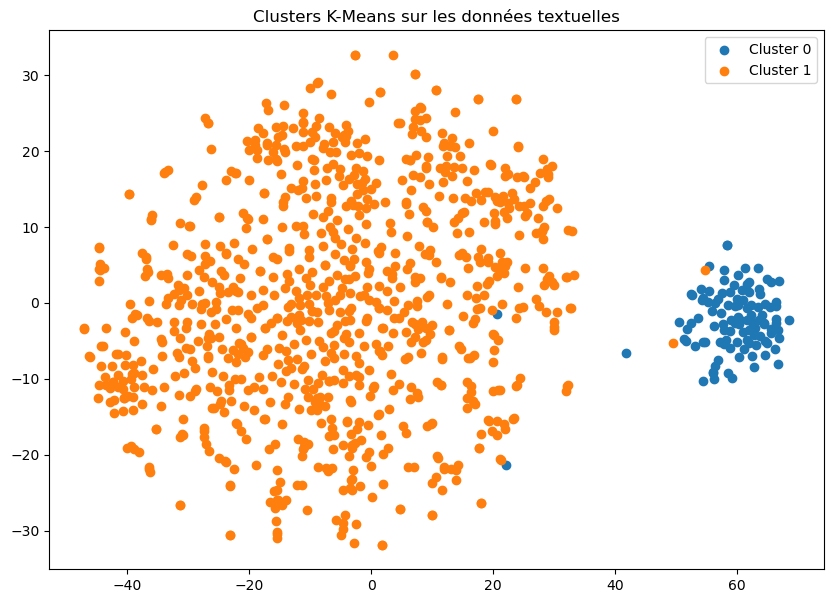

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Vérifier la taille des données
n_samples = X.shape[0]
perplexity = min(30, n_samples - 1)  # La perplexité doit être inférieure au nombre d'échantillons

# Réduction de dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
X_2d = tsne.fit_transform(X)

# Tracer les clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(X_2d[df["cluster"] == cluster, 0], X_2d[df["cluster"] == cluster, 1], label=f"Cluster {cluster}")

plt.legend()
plt.title("Clusters K-Means sur les données textuelles")
plt.show()


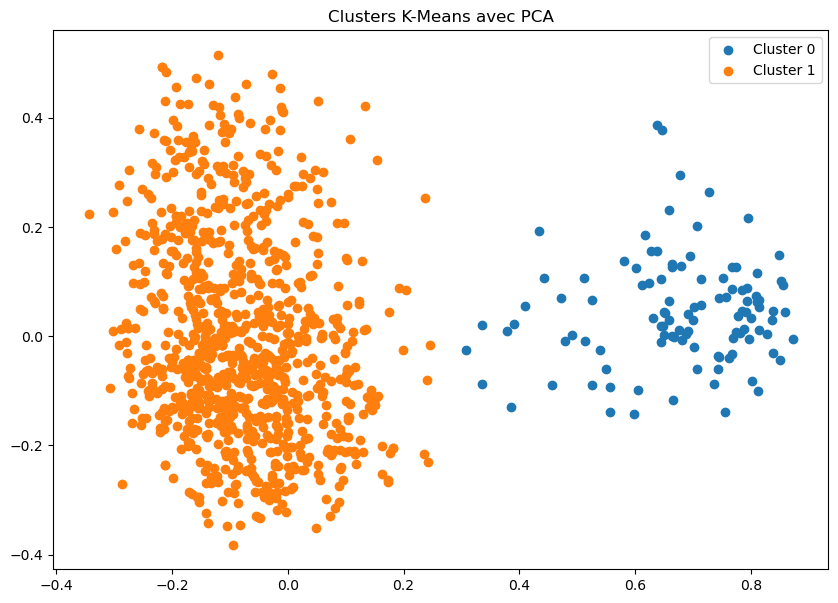

In [8]:
from sklearn.decomposition import PCA

# Réduction de dimensions avec PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Tracer les clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(X_2d[df["cluster"] == cluster, 0], X_2d[df["cluster"] == cluster, 1], label=f"Cluster {cluster}")

plt.legend()
plt.title("Clusters K-Means avec PCA")
plt.show()


*Mise en place des résulats sur MongoDB*

In [13]:
#print(X,"\n")
#print(df["cleaned_text"].head())

***Fichier du model de création de thème par cluster***

In [8]:
import numpy as np

# Exemple : Liste des vecteurs d'embedding et des clusters
# X est une matrice d'embedding où chaque ligne correspond à un vecteur
# df['cluster'] contient les étiquettes des clusters
clusters = df["cluster"].unique()
cluster_embeddings = {cluster: X[df["cluster"] == cluster] for cluster in clusters}


In [9]:
# Calculer le vecteur central pour chaque cluster
cluster_centroids = {
    cluster: np.mean(embeddings, axis=0)
    for cluster, embeddings in cluster_embeddings.items()
}


Génération avec thèmes imposés

In [10]:
from sentence_transformers import SentenceTransformer

# Charger un modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Liste de mots de vocabulaire potentiellement pertinents (vous pouvez personnaliser)
vocabulary = [ "API", "machine learning", "JavaScript", "Python", "database", "web"]

# Embeddings des mots du vocabulaire
vocabulary_embeddings = sentence_model.encode(vocabulary)

# Trouver le mot le plus proche pour chaque cluster
cluster_themes = {}
for cluster, centroid in cluster_centroids.items():
    similarities = np.dot(vocabulary_embeddings, centroid)  # Produit scalaire
    best_match_index = np.argmax(similarities)  # Indice du mot le plus proche
    cluster_themes[cluster] = vocabulary[best_match_index]

print("Thèmes des clusters :")
for cluster, theme in cluster_themes.items():
    print(f"Cluster {cluster}: {theme}")

Thèmes des clusters :
Cluster 1: web
Cluster 0: Python


Génération avec thèmes récupérés des données

In [11]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Charger un modèle Sentence Transformers
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Fonction pour extraire des mots-clés des données du cluster
def extract_keywords_from_cluster(data, top_n=5):
    """
    Extrait les mots-clés les plus pertinents d'un cluster à l'aide de TF-IDF.
    """
    #vectorizer = TfidfVectorizer(stop_words='english')  # Enlever les mots courants comme "the", "and"
    tfidf_matrix = vectorizer.fit_transform(data)  # Calculer les scores TF-IDF
    feature_names = vectorizer.get_feature_names_out()
    
    # Moyenne des scores TF-IDF pour tous les documents
    tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)
    
    # Récupérer les mots avec les scores les plus élevés
    top_indices = np.argsort(tfidf_scores)[::-1][:top_n]
    top_keywords = [feature_names[i] for i in top_indices]
    return top_keywords


cluster_themes = {}
cluster_data = df["cleaned_text"].groupby(df["cluster"]).apply(list).to_dict()


# Trouver le thème le plus proche pour chaque cluster
for cluster, texts in cluster_data.items():
    # Extraire des mots-clés depuis les textes du cluster
    keywords = extract_keywords_from_cluster(texts)
    
    # Calculer les embeddings des mots-clés extraits
    keyword_embeddings = sentence_model.encode(keywords)
    
    # Centroid du cluster (remplacez-le par le centroid calculé si disponible)
    centroid = np.mean(sentence_model.encode(texts), axis=0)  # Moyenne des embeddings des textes
    
    # Trouver le mot-clé le plus proche du centroïde
    similarities = np.dot(keyword_embeddings, centroid)  # Produit scalaire
    best_match_index = np.argmax(similarities)
    cluster_themes[cluster] = keywords[best_match_index]

print("Thèmes des clusters :")
for cluster, theme in cluster_themes.items():
    print(f"Cluster {cluster}: {theme}")


Thèmes des clusters :
Cluster 0: python
Cluster 1: code
